# Global Sea Surface Temperature Trends

**Objective: Calculate Global Rates of Change, Highlight Regions of Specific Percentiles.**

## Product 4: Global Change Rate Netcdfs, Percentile Rankings

Steps for calculating change rates across netcdf files can be found here: http://atedstone.github.io/rate-of-change-maps/. The desired end result is a map with the global OISST extent that displays the sea surface temperature warming rate of each cell. Depending on how difficult/time-consuming that is to generate a second variable ranking the warming rates will also be added. In this way areas can be highlighted by how rapidly they are warming relative to other areas on the planet.

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os

# # Ensure we're in correct directory/volume
# os.chdir("/home/jovyan/NSF OKN Demo Data/oisst/annual_observations") #when working in container

#Suppress divide by NA error
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Regional differences in sea surface temperature change-rates are important for management considerations surrounding ecosystem resiliency around climate change. An important step in this process is mapping out what the change rates are globally.

### Loading the OISST Files:

First step is to get everything loaded, so step one is to load in all the yearly oisst data files. The files all have the same naming convention so we just need to iterate through the available years to generate a list of all the files.

In [42]:
#Generate list of file names from start and end + 1
start_year = 1982
end_year = 2020
end_year = end_year + 1
my_years = np.arange(start_year, end_year, 1)
nc_files = []
for i in my_years:
    nc_files.append("NSF OKN Demo Data/oisst/annual_observations/sst.day.mean." + str(i) + ".v2.nc")
    

Once all the file names are generated they can be loaded as a single object using xarray's open_mfdataset()

In [43]:
#clim = xr.open_mfdataset('*.nc', parallel = True, combine = 'by_coords')
oisst = xr.open_mfdataset(nc_files, parallel = False, combine = "by_coords")
oisst

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 14199)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2020-11-15
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(365, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

# Get Annual Averages

Having an annual rate of change rather than a daily rate of change does two things for us. Its a more tangible rate for comparison, and it makes computation take a great deal less time.

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


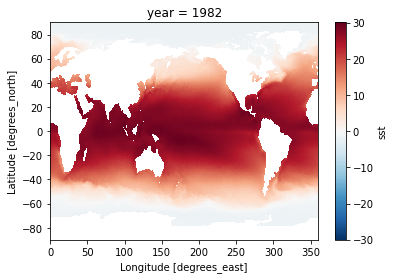

In [44]:
year_avg = oisst.groupby('time.year').mean()
year_avg['sst'].sel(year = 1982).plot()


## Calculating Trends

In [45]:
# Pull arrays of the sea surface temperatures and the time dimensions
vals = year_avg.sst.values
years = year_avg.year.values

# Reshape to an array with as many rows as years and as many columns as there are pixels
vals2 = vals.reshape(len(years), -1)

# Do a first-degree polyfit (i.e. a line)
regressions = np.polyfit(years, vals2, 1)

# Get the coefficients back
trends = regressions[0, :].reshape(vals.shape[1], vals.shape[2])

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Re-format the numpy array to an xarray dataarray, do some plotting for verification.

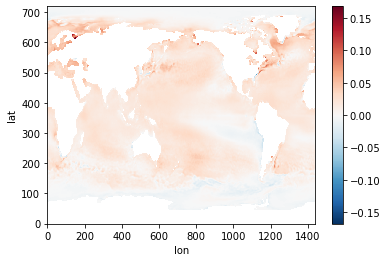

In [48]:
trend_xr = xr.DataArray(trends)
trend_xr = trend_xr.rename({"dim_0" : "lat", "dim_1" : "lon"})
trend_xr.plot()


In [56]:
# What is going on with the regressions array?
regressions.shape

(2, 1036800)

# Next Steps:

 - Get the percentiles of these warming rate values
 - Put these warming rates & their percentiles into a DataArrayDataset 
 - Pull lat/lon dimensions from original, apply attributes and metadata that details start/end date
 - Export Somewhere